<a href="https://colab.research.google.com/github/Sri-Pooja00/2203A51341_NLP/blob/main/2203A51341_10_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, z_dim)  # Log variance
        self.fc3 = nn.Linear(z_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparameterization trick

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [4]:
def train_vae(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')


In [5]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train_vae(model, train_loader, optimizer, epoch)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:04<00:00, 2427541.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 488302.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 1762004.26it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 5627925.78it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Loss: 163.89996692708334
Epoch 2, Loss: 121.32620685221355
Epoch 3, Loss: 114.59729873046875
Epoch 4, Loss: 111.55318525390625
Epoch 5, Loss: 109.76969099934895
Epoch 6, Loss: 108.57620431315104
Epoch 7, Loss: 107.81978510742188
Epoch 8, Loss: 107.11825266927083
Epoch 9, Loss: 106.63003069661458
Epoch 10, Loss: 106.19241801757812


In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=784):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.fc(z)

class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.fc(img)


In [7]:
def train_gan(generator, discriminator, dataloader, optimizer_G, optimizer_D, criterion, num_epochs=10):
    for epoch in range(num_epochs):
        for real_imgs, _ in dataloader:
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.view(batch_size, -1)

            # Train Discriminator
            optimizer_D.zero_grad()
            z = torch.randn(batch_size, 100)
            fake_imgs = generator(z)
            real_loss = criterion(discriminator(real_imgs), torch.ones(batch_size, 1))
            fake_loss = criterion(discriminator(fake_imgs.detach()), torch.zeros(batch_size, 1))
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = criterion(discriminator(fake_imgs), torch.ones(batch_size, 1))
            g_loss.backward()
            optimizer_G.step()

        print(f'Epoch {epoch+1}/{num_epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')


In [8]:
z_dim = 100
generator = Generator(z_dim)
discriminator = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

train_gan(generator, discriminator, train_loader, optimizer_G, optimizer_D, criterion)


Epoch 1/10, D Loss: 1.362480640411377, G Loss: 0.937217652797699
Epoch 2/10, D Loss: 1.2398179769515991, G Loss: 0.727139413356781
Epoch 3/10, D Loss: 1.2207705974578857, G Loss: 0.8145794868469238
Epoch 4/10, D Loss: 0.9662123322486877, G Loss: 0.98636394739151
Epoch 5/10, D Loss: 0.928280770778656, G Loss: 1.1312379837036133
Epoch 6/10, D Loss: 0.6804876327514648, G Loss: 1.5596694946289062
Epoch 7/10, D Loss: 1.1636855602264404, G Loss: 1.2678972482681274
Epoch 8/10, D Loss: 0.6971800327301025, G Loss: 1.502625584602356
Epoch 9/10, D Loss: 0.7651082277297974, G Loss: 1.3555645942687988
Epoch 10/10, D Loss: 0.7797284126281738, G Loss: 1.4559335708618164


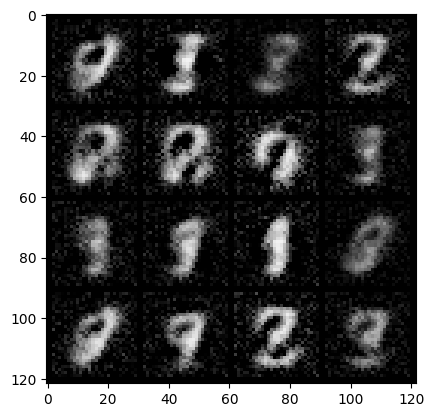

In [13]:
import torchvision # Importing the torchvision module. This line was missing and caused the error.
import torch
import matplotlib.pyplot as plt
import numpy as np

z = torch.randn(16, z_dim)  # Sample random latent points
with torch.no_grad():
    generated_imgs = generator(z).view(-1, 1, 28, 28)

# Plot images
grid_img = torchvision.utils.make_grid(generated_imgs, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()
